# Bài tập thực hành Phân tích và xử lý ảnh 07
## MSSV:  18110014 - Họ tên: Nguyễn Phú Thành

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import pandas as pd

In [2]:
def imShows(Images, Labels = None, rows = 1, cols = 1):
    imagesArray = list(Images)
    labelsArray = [f"Image {i + 1}" for i in range(len(imagesArray))] if Labels is None else list(Labels)
    figsize = (20, 20) if ((rows == 1) and (cols == 1)) else (cols * 8, rows * 5)
    fig = plt.figure(figsize = figsize)
    for i in range(1, rows * cols + 1):
        ax = fig.add_subplot(rows, cols, i)
        image = imagesArray[i - 1]
        cmap = plt.cm.gray if (len(image.shape) < 3) else None
        ax.imshow(image, cmap = cmap)
        ax.set(title = labelsArray[i - 1], xticks = [], yticks = [])
    plt.show()
def showThreeImages(IM1, IM2, IM3, Labels = None):
    imShows([IM1, IM2, IM3], Labels = Labels, rows = 1, cols = 3)
def showTwoImages(IM1, IM2, Labels = None):
    imShows([IM1, IM2], Labels = Labels, rows = 1, cols = 2)
def showOneImage(IM1, Labels = None):
    imShows([IM1], Labels = Labels)
def showListImages(listImage, listLabels = None, rows = 1, cols = 1):
    imShows(listImage, Labels = listLabels, rows = rows, cols = cols)

## 1/ Với mỗi các phương pháp Morphology sau kiếm 1 ảnh từ internet làm ví dụ thể hiện rõ kết quả nhất :
    • Dilation 
    • Erosion
    • Closing
    • Opening
    • Gradient 

In [3]:
class MaskMorphology:
    
    @staticmethod
    @np.vectorize
    def OR(a, b):
        return (a or b)
    
    @staticmethod
    @np.vectorize
    def AND(a, b):
        return (a and b)
    
    @staticmethod
    @np.vectorize
    def NOT(a):
        return int(not a)
    
    def __init__(self, mask):
        self.orig = mask.copy()
        self.orig = self.orig.astype(np.uint8)
    def union(self, other):
        return MaskMorphology(MaskMorphology.OR(self.orig, other.orig))
    
    def intersection(self, other):
        return MaskMorphology(MaskMorphology.AND(self.orig, other.orig))
    
    def complement(self):
        return MaskMorphology(MaskMorphology.NOT(self.orig))
    
    def difference(self, other):
        not_other = MaskMorphology.NOT(other.orig)
        return MaskMorphology(MaskMorphology.AND(self.orig, not_other))
    
    def isSubset(self, other):
        intersect = self.intersection(other)
        return (intersect.orig == self.orig).all()
    
    def isEmpty(self):
        return (self.orig == 0).all()

In [4]:
def getNeighborhood(i, j, mask, se_shape):
    se_rows, se_cols = se_shape[:2]
    pad_row = 0 if se_rows % 2 == 0 else 1
    pad_col = 0 if se_cols % 2 == 0 else 1
    return MaskMorphology(
        mask.orig[(i - se_rows//2) : (i + se_rows //2 + pad_row), (j - se_cols//2) : (j + se_cols//2 + pad_col)])

In [5]:
def reflection(mask):
    shape = mask.orig.shape
    center = (shape[0]//2, shape[1]//2)
    returnMask = np.zeros(shape, dtype = mask.orig.dtype)
    
    c_x, c_y = center
    
    for i in range(shape[0]):
        for j in range(shape[1]):
            new_i, new_j = 2 * c_x - i, 2 * c_y - j
            returnMask[new_i, new_j] = mask.orig[i, j]
    return MaskMorphology(returnMask)

In [6]:
def dilation(se, mask, iterations = 1):
    se = reflection(se)
    shape = mask.orig.shape
    se_shape = se.orig.shape
    pad_mask = np.zeros((se_shape[0] * 2 + shape[0], se_shape[1] * 2 + shape[1]))
    output = np.zeros(pad_mask.shape, dtype = np.uint8)
    pad_mask[se_shape[0] : (se_shape[0] + shape[0]), se_shape[1] : (se_shape[1] + shape[1])] = mask.orig.copy()
    
    pad_mask = MaskMorphology(pad_mask)
    
    for _ in range(iterations):
        for i in range(se_shape[0], se_shape[0] + shape[0]):
            for j in range(se_shape[1], se_shape[1] + shape[1]):
                neighbor = getNeighborhood(i, j, pad_mask, se_shape)
                if not neighbor.intersection(se).isEmpty():
                    output[i, j] = 1
        pad_mask.orig = output.copy()
    return MaskMorphology(output[se_shape[0] : (se_shape[0] + shape[0]), se_shape[1] : (se_shape[1] + shape[1])])

In [7]:
def erosion(se, mask, iterations = 1):
    shape = mask.orig.shape
    se_shape = se.orig.shape
    pad_mask = np.zeros((se_shape[0] * 2 + shape[0], se_shape[1] * 2 + shape[1]))
    output = np.zeros(pad_mask.shape)
    pad_mask[se_shape[0] : (se_shape[0] + shape[0]), se_shape[1] : (se_shape[1] + shape[1])] = mask.orig.copy()
    
    pad_mask = MaskMorphology(pad_mask)
    
    for _ in range(iterations):
        for i in range(se_shape[0], se_shape[0] + shape[0]):
            for j in range(se_shape[1], se_shape[1] + shape[1]):
                neighbor = getNeighborhood(i, j, pad_mask, se_shape)
                if se.isSubset(neighbor):
                    output[i, j] = 1
        pad_mask.orig = output.copy()
    return MaskMorphology(output[se_shape[0] : (se_shape[0] + shape[0]), se_shape[1] : (se_shape[1] + shape[1])])

In [8]:
def opening(se, mask):
    return dilation(se, erosion(se, mask))
def closing(se, mask):
    return erosion(se, dilation(se, mask))
def gradient(se, mask):
    dilated = dilation(se, mask)
    erode = erosion(se, mask)
    return dilated.difference(erode)

## • Dilation

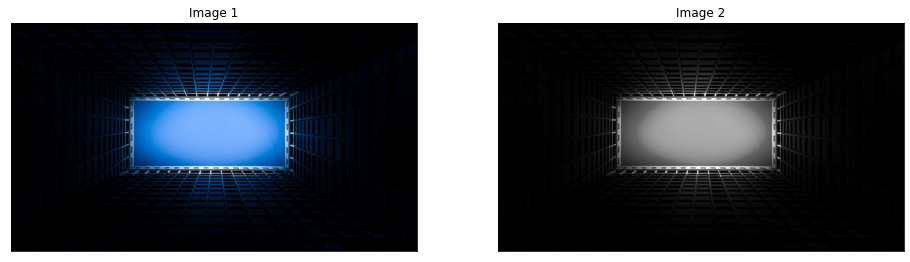

In [9]:
image_color = plt.imread('rect.jpg')
image_gray = cv2.cvtColor(image_color, cv2.COLOR_RGB2GRAY)
showTwoImages(image_color, image_gray)

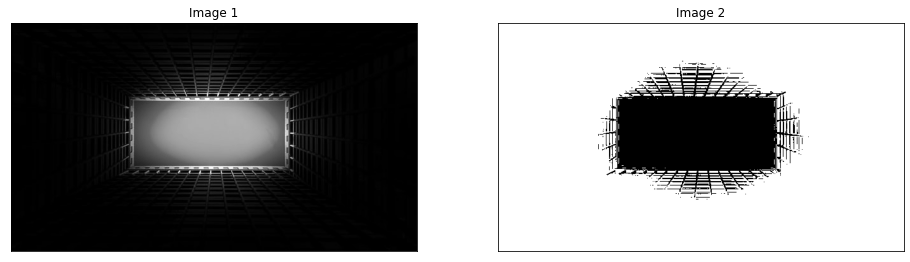

In [10]:
mask = (image_gray < 30).astype(np.uint8)
showTwoImages(image_gray, mask)

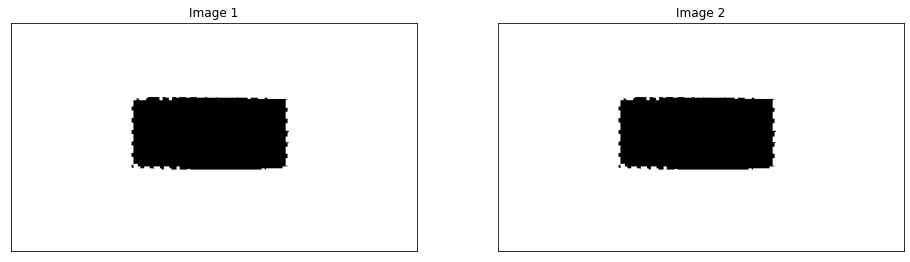

In [11]:
kernel = np.ones((3, 3), dtype = np.uint8)
cv2_dilated = cv2.dilate(mask, kernel, iterations = 2)
implement_dilated = dilation(MaskMorphology(kernel), MaskMorphology(mask), iterations = 2)
showTwoImages(cv2_dilated, implement_dilated.orig)

## • Erosion

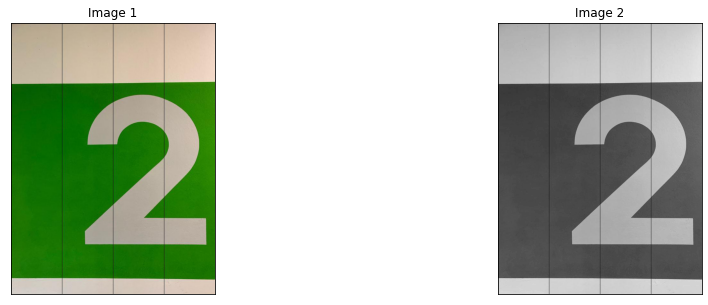

In [12]:
image_color = plt.imread('number.jpg')
image_gray = cv2.cvtColor(image_color, cv2.COLOR_RGB2GRAY)
showTwoImages(image_color, image_gray)

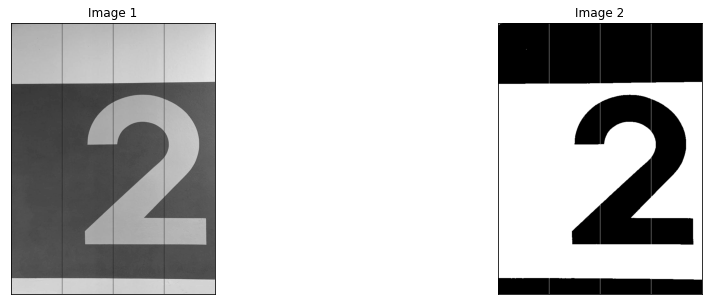

In [13]:
mask = (image_gray < 150).astype(np.uint8)
showTwoImages(image_gray, mask)

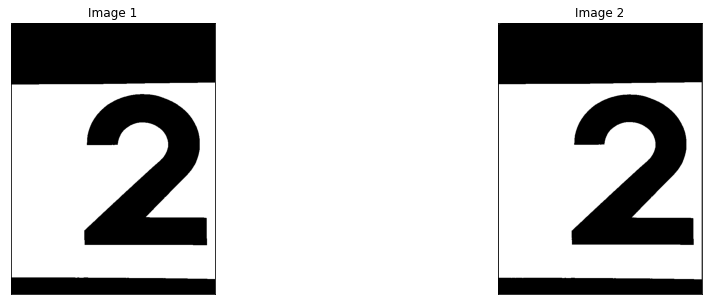

In [14]:
kernel = np.ones((3,3),np.uint8)
cv2_erode = cv2.erode(mask, kernel, iterations = 2)
implement_erode = erosion(MaskMorphology(kernel), MaskMorphology(mask), iterations = 2)
showTwoImages(cv2_erode, implement_erode.orig)

## • Closing

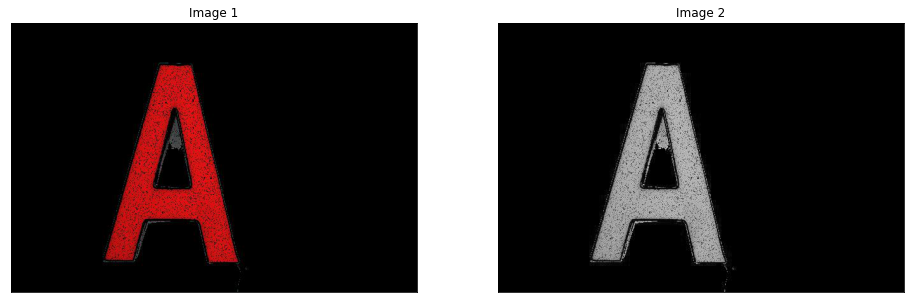

In [15]:
image_color = plt.imread('letter_a_closing.jpg')
image_gray = cv2.cvtColor(image_color, cv2.COLOR_RGB2GRAY)
showTwoImages(image_color, image_gray)

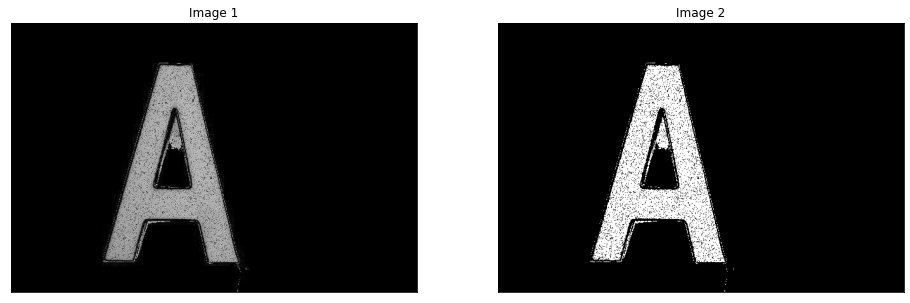

In [16]:
mask = (image_gray > 50).astype(np.uint8)
showTwoImages(image_gray, mask)

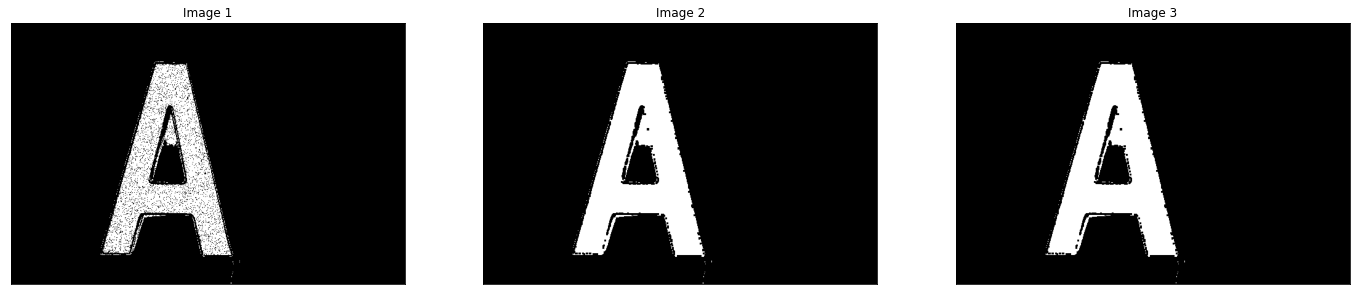

In [17]:
kernel = np.ones((3, 3),  dtype = np.uint8)
cv2_closing = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
implement_closing = closing(MaskMorphology(kernel), MaskMorphology(mask))
showThreeImages(mask, cv2_closing, implement_closing.orig)

## • Opening

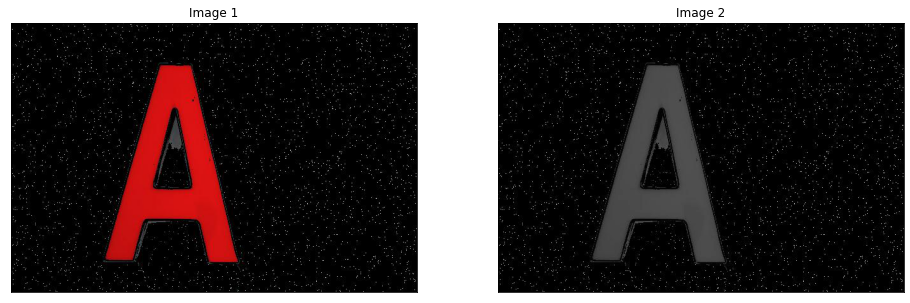

In [18]:
image_color = plt.imread('letter_a_opening.jpg')
image_gray = cv2.cvtColor(image_color, cv2.COLOR_RGB2GRAY)
showTwoImages(image_color, image_gray)

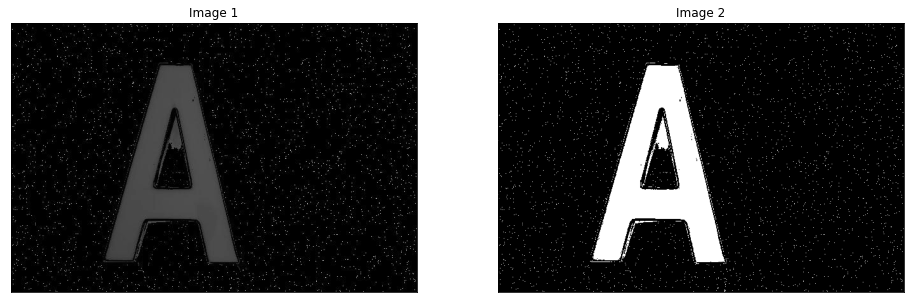

In [19]:
mask = (image_gray > 50).astype(np.uint8)
showTwoImages(image_gray, mask)

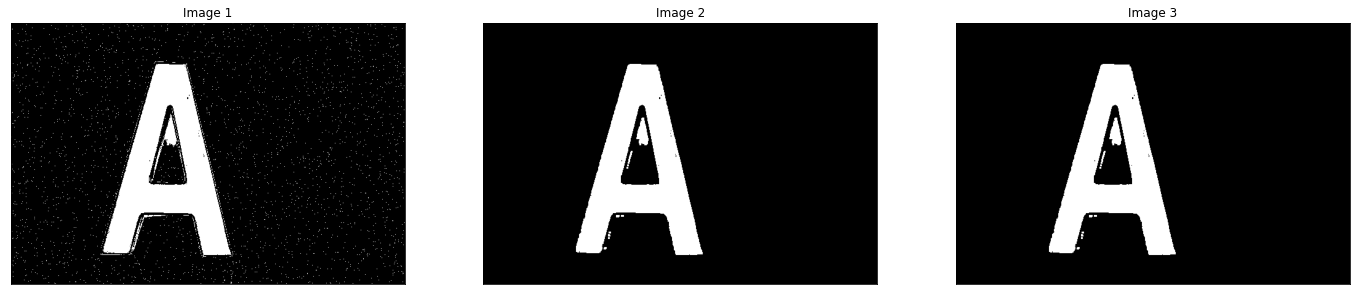

In [20]:
kernel = np.ones((3, 3),  dtype = np.uint8)
cv2_opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
implement_opening = opening(MaskMorphology(kernel), MaskMorphology(mask))
showThreeImages(mask, cv2_opening, implement_opening.orig)

## • Gradient

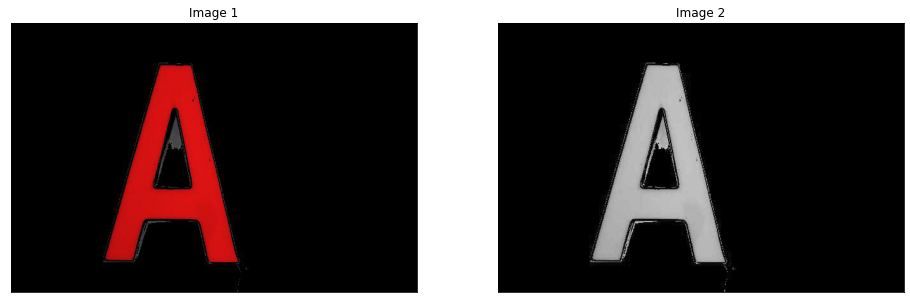

In [21]:
image_color = plt.imread('letter_a_gradient.jpg')
image_gray = cv2.cvtColor(image_color, cv2.COLOR_RGB2GRAY)
showTwoImages(image_color, image_gray)

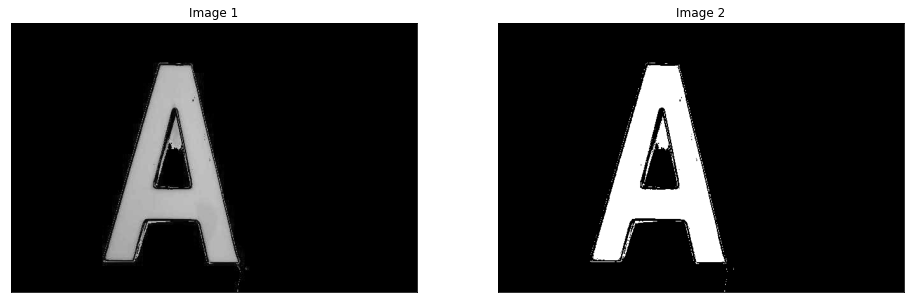

In [22]:
mask = (image_gray > 50).astype(np.uint8)
showTwoImages(image_gray, mask)

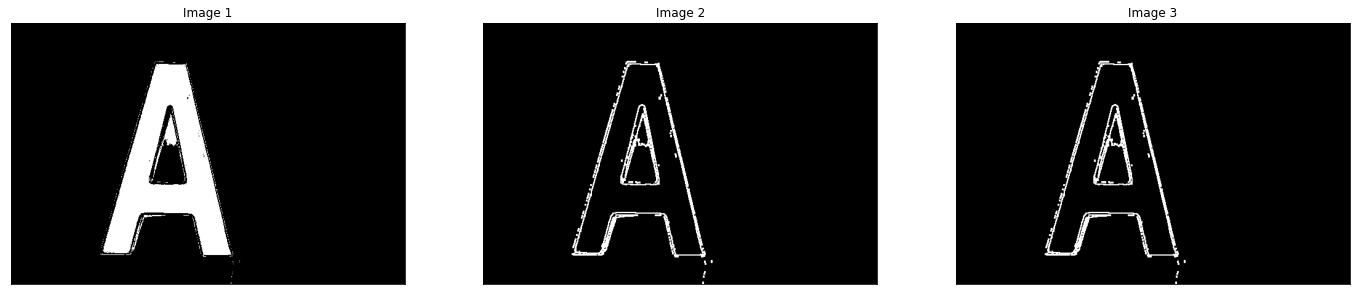

In [23]:
kernel = np.ones((3, 3),  dtype = np.uint8)
cv2_gradient = cv2.morphologyEx(mask, cv2.MORPH_GRADIENT, kernel)
implement_gradient = gradient(MaskMorphology(kernel), MaskMorphology(mask))
showThreeImages(mask, cv2_gradient, implement_gradient.orig)

## 2/ Kiếm một ảnh biển số xe và thực hiện kết hợp các phương pháp Morphology để trích các con số trên biển số xe 

In [24]:
def extractEach(df, img):
    listImg = []
    for index, rw in df.iterrows():
        x, y, w, h = rw['x'], rw['y'], rw['w'], rw['h']
        extracted = img[y : (y + h), x : (x + w), :].copy()
        listImg.append(extracted)
    return listImg

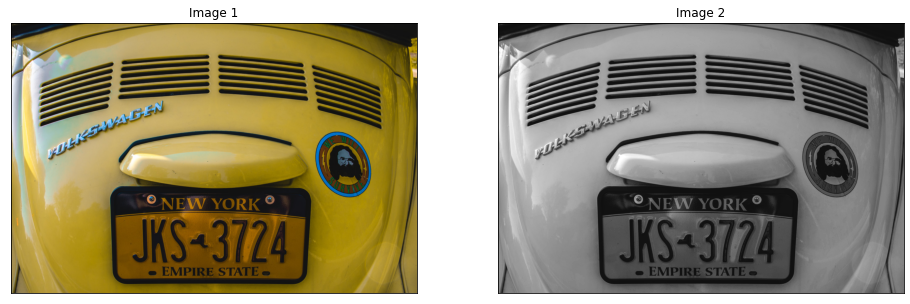

In [25]:
image_color = plt.imread('license_plate.jpg')
image_gray = cv2.cvtColor(image_color, cv2.COLOR_RGB2GRAY)
showTwoImages(image_color, image_gray)

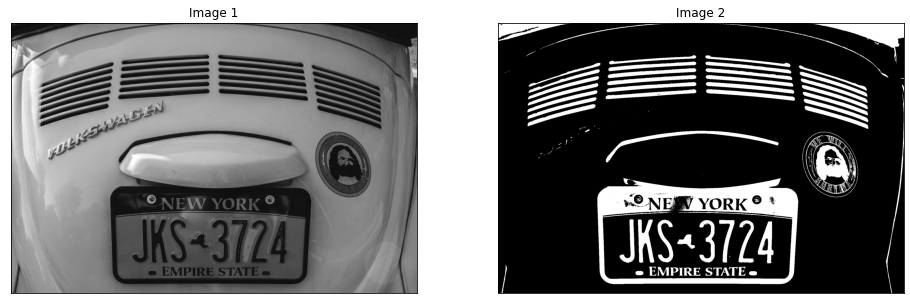

In [26]:
mask = (image_gray < 50).astype(np.uint8)
showTwoImages(image_gray, mask)

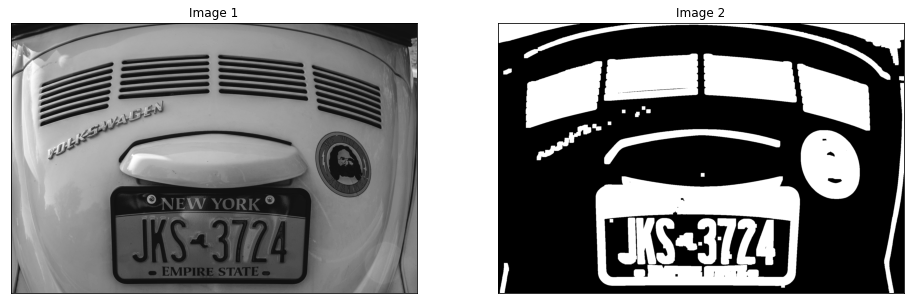

In [27]:
kernel = np.ones((5, 5), dtype = np.uint8)
image_dilated = cv2.dilate(mask, kernel, iterations = 4)
showTwoImages(image_gray, image_dilated)

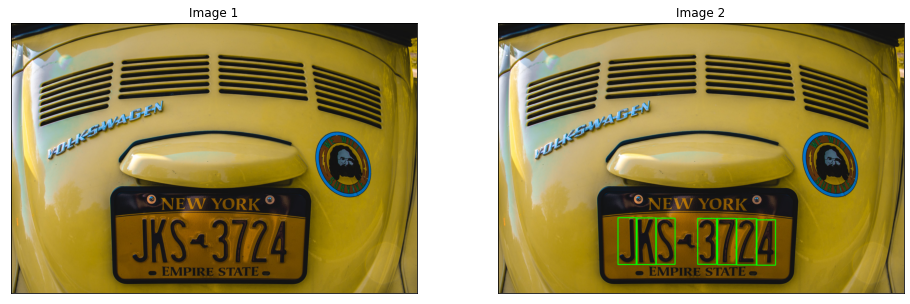

In [28]:
result = image_color.copy()
contours, hierarchy = cv2.findContours(image_dilated,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
count = 0
info = pd.DataFrame(columns = ["x", "y", "w", "h"])
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if(w * h > 18000) and (w * h < 27000):
        cv2.rectangle(result,(x,y),(x + w, y + h), (0,255,0), 4)
        info.loc[count,:] = (x,y,w,h)
        count = count + 1
info = info.astype(int)
showTwoImages(image_color, result)

In [29]:
lstImg = extractEach(info, image_color)
lstImg = [image_color] + lstImg

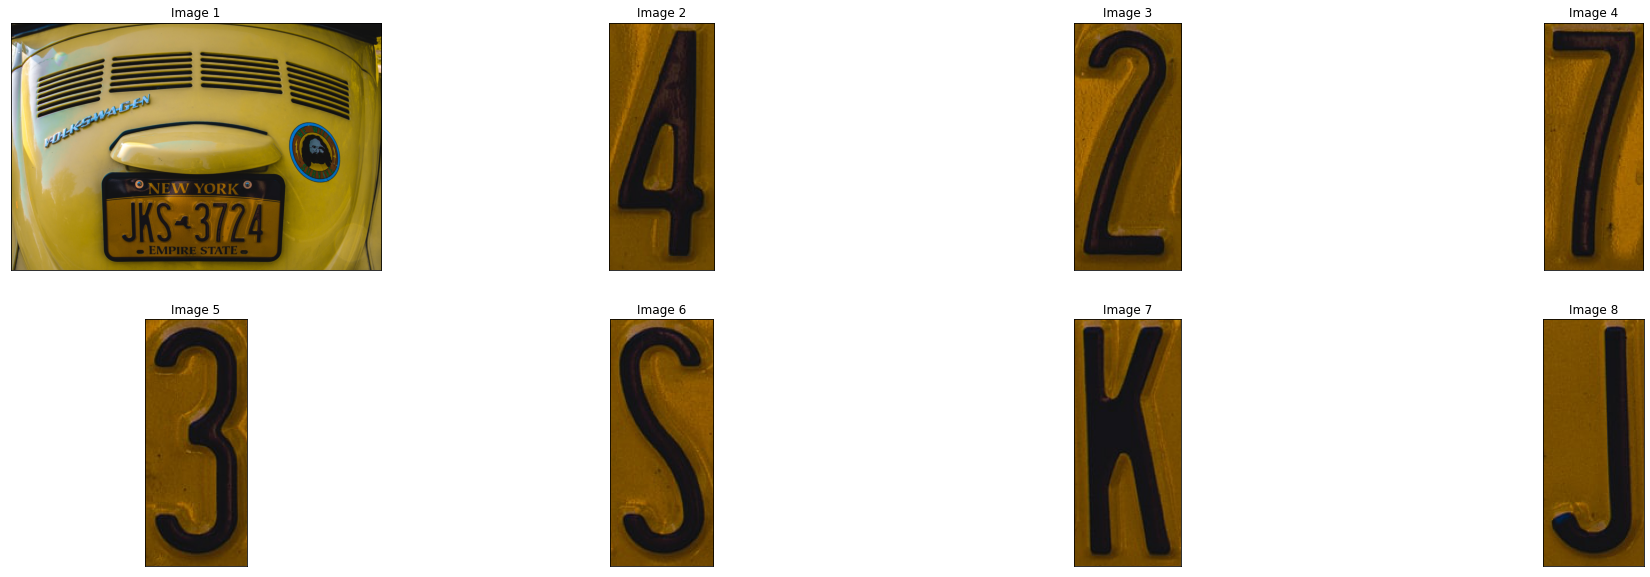

In [30]:
showListImages(lstImg, rows = 2, cols = 4)

## 3/ Kiếm một ảnh chụp biển hiệu shop bán hàng kết hợp các phương pháp Morphology để trích các thông tin cửa hiệu

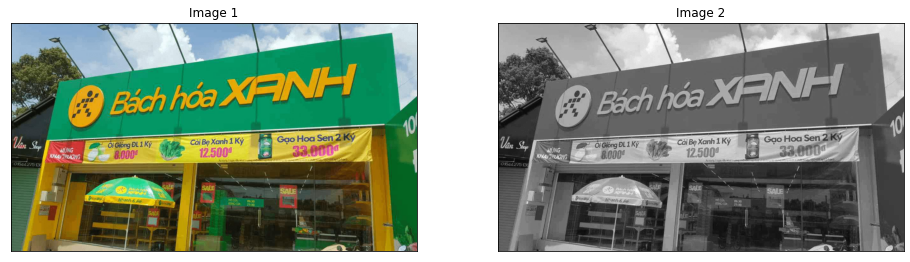

In [31]:
image_color = plt.imread('shop_sign.jpg')
image_gray = cv2.cvtColor(image_color, cv2.COLOR_RGB2GRAY)
showTwoImages(image_color, image_gray)

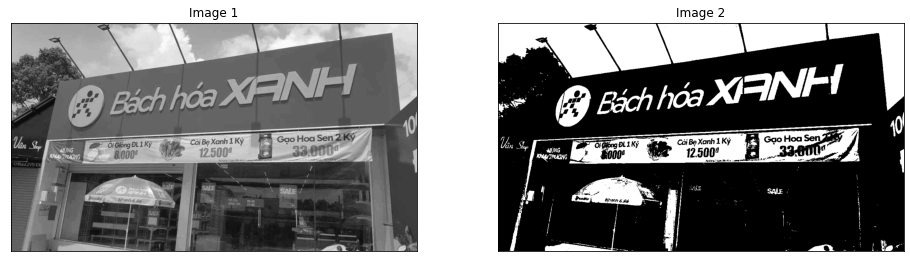

In [32]:
mask = (image_gray > 150).astype(np.uint8)
showTwoImages(image_gray, mask)

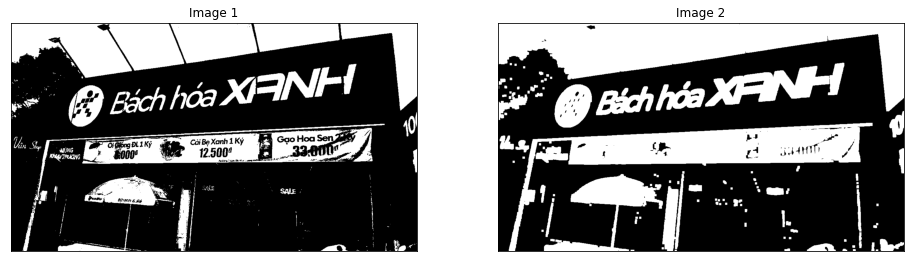

In [33]:
image_dilated = cv2.dilate(mask, np.ones((3,3)), iterations = 3)
showTwoImages(mask, image_dilated)

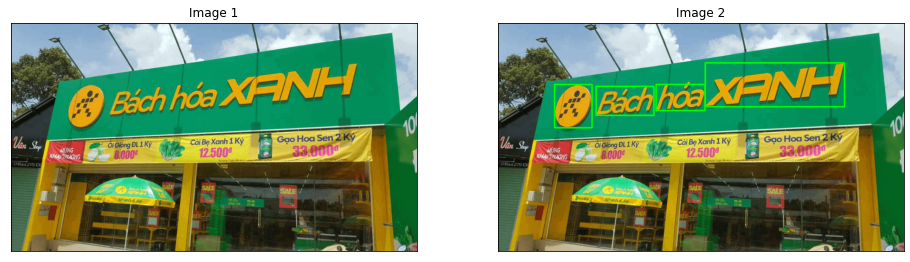

In [34]:
result = image_color.copy()
contours, hierarchy = cv2.findContours(image_dilated,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
count = 0
info = pd.DataFrame(columns = ["x", "y", "w", "h"])
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    if((12000 < w * h < 17000) and (w/h > 0.5)) or (60000 < w * h < 70000):
        cv2.rectangle(result,(x,y),(x + w, y + h), (0,255,0), 4)
        info.loc[count,:] = (x,y,w,h)
        count = count + 1
info = info.astype(int)
showTwoImages(image_color, result)

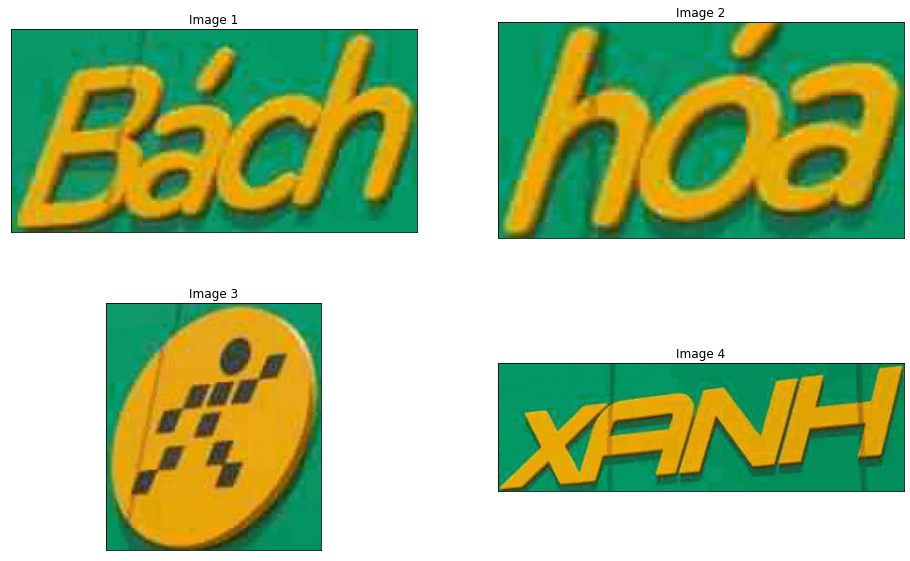

In [35]:
lstImg = extractEach(info, image_color)
showListImages(lstImg, rows = 2, cols = 2)

## 4/ Chụp 1 dòng chat của bạn và sau đó dùng Morphology để trích các dòng chat đó ra

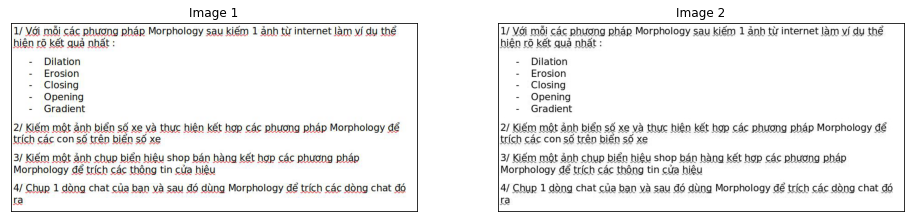

In [36]:
image_color = plt.imread('text.jpg')
image_gray = cv2.cvtColor(image_color, cv2.COLOR_RGB2GRAY)
showTwoImages(image_color, image_gray)

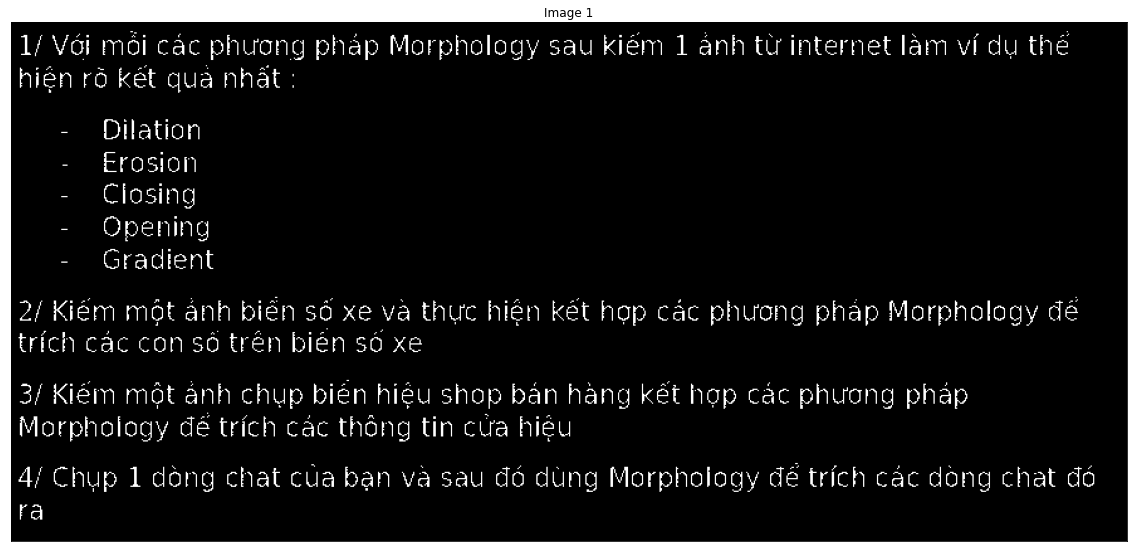

In [37]:
mask = (image_gray < 50).astype(np.uint8)
showOneImage(mask)

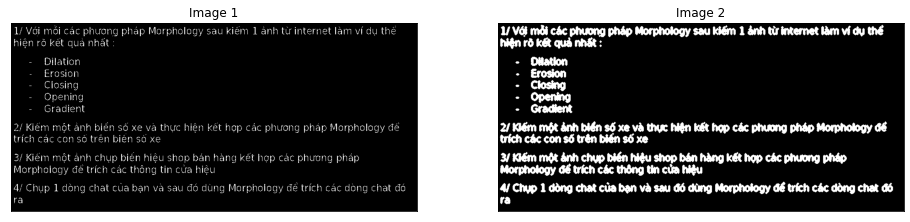

In [38]:
kernel = np.array([
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0]
], dtype = np.uint8)

image_dilated = cv2.dilate(mask, kernel, iterations = 2)
showTwoImages(mask, image_dilated)

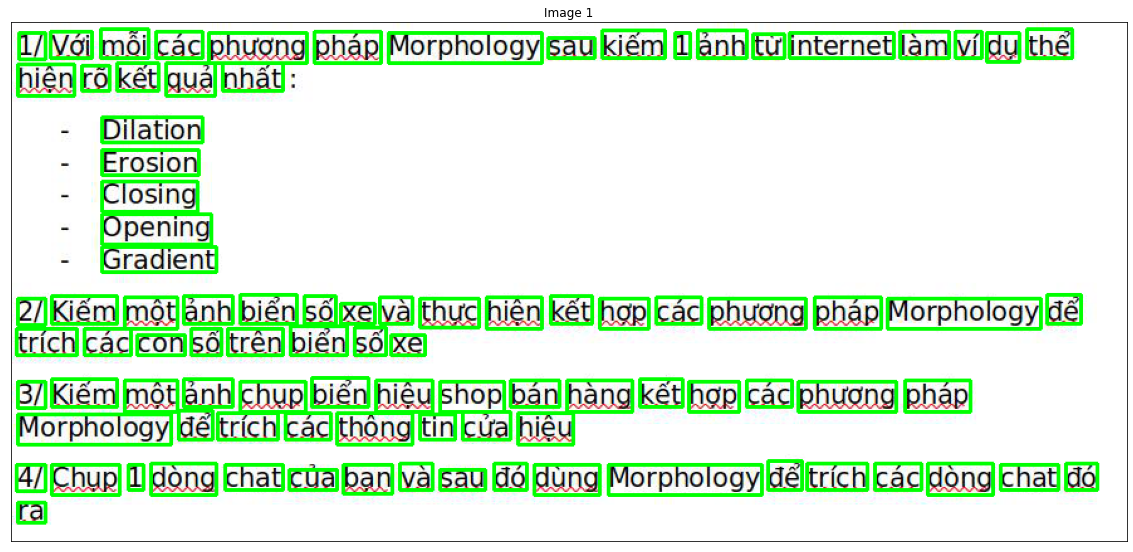

In [39]:
result = image_color.copy()
contours, hierarchy = cv2.findContours(image_dilated,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
count = 0
info = pd.DataFrame(columns = ["x", "y", "w", "h"])
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    if(w * h > 175):
        cv2.rectangle(result,(x,y),(x + w, y + h), (0,255,0), 2) 
        info.loc[count,:] = (x,y,w,h)
        count = count + 1
info = info.astype(int)
showOneImage(result)